In [1]:
"""
NEURON simulation of a one-dimensional network of excitatory and inhibitory neurons
with spike-timing-dependent plasticity (STDP) to study self-organization
under different noise conditions.

Network Structure:
- 100 Excitatory (E) neurons: Two compartments (soma, dendrite).
- 25 Inhibitory (I) neurons: Single compartment (SST-like).
- 100 Poisson input sources projecting to E-neuron dendrites.

Connections:
1.  Input -> E (dendrite): Spatially tuned, Bell-shaped weights. Hebbian STDP.
2.  E -> I (soma): Excitatory, plastic with Hebbian STDP.
3.  I -> E (distal dendrite): Inhibitory feedback. Symmetric STDP with baseline depression.
4.  Noise 1 -> E (soma): Poisson noise source.
5.  Noise 2 -> E (distal dendrite): Poisson noise source.

The script sets up the network, runs the simulation, and records spike data.
"""

from neuron import n, gui
from neuron.units import ms, mV, µm
import mycells
import random, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# --- 0. i/o ---
plotdir = "/Users/bs3667/NYU Langone Health Dropbox/Shen Bo/Bo Shen Working files/STDP_Project0/Revision2/NEURON"

# --- 1. Simulation Parameters ---
n.load_file("stdrun.hoc")
random.seed(42)
np.random.seed(42)
SIM_DURATION = 2000 * ms

# --- 2. Network Parameters ---
N_E = 100  # Number of excitatory neurons
N_I = 25   # Number of inhibitory neurons
N_INPUT = 100 # Number of external input sources
SPACE_EXTENT_X = 300 * µm # extent over x-axis
SPACE_EXTENT_Y = 100 * µm # extent over y-axis
gbar_AMPA = 1.4e-3 # µS -> 1.4 nS, maximum conductance of a single point AMPA receptor
gbar_GABA = 3.5e-3 # µS -> 3.5 nS, maximum conductance of a single point GABA receptor

# Test a single pair of E-I network
__Set up the network with one pair of E and I cells__

The E cell has one soma and two dendrites

The I cell is simplified as one soma body

In [2]:
E_SST = mycells.Belt(NE=1, NI=1, SPACE_EXTENT_X = 100, SPACE_EXTENT_Y = 10, Itype = "SST")
E_PV = mycells.Belt(NE=1, NI=1, SPACE_EXTENT_X = -100, SPACE_EXTENT_Y = 10, Itype = "PV")

shape_window = n.PlotShape(True)
shape_window.show(0)
n.topology()


|-|       E[0].soma(0-1)
   `--|       E[0].dend1(0-1)
   `--|       E[0].dend2(0-1)
|-|       I[0].soma(0-1)
|-|       E[0].soma(0-1)
   `--|       E[0].dend1(0-1)
   `--|       E[0].dend2(0-1)
|-|       I[0].soma(0-1)



1.0

In [6]:
print(", ".join(item for item in dir(E_SST.Ecells[0]._ncs[0]) if not item.startswith("__")))

active, baseattr, delay, event, get_recordvec, hname, hocobjptr, postcell, postcelllist, postloc, postseg, pre, precell, precelllist, prelist, preloc, preseg, record, same, setpost, srcgid, syn, synlist, threshold, valid, wcnt, weight, x


In [14]:
E_PV.Ecells[0]._ncs[0].weight[0]
E_PV.Icells[0]._ncs[0].weight[0]

0.0035

__Single-spike from the I cell to test IPCS/P on the E cell__

In [ ]:
try:
    del Stim
except NameError:
    print("No action required")
Stim = n.NetStim()
Stim.number = 1
Stim.start = 1
# feedforward inhibition
nc = n.NetCon(Stim, E_SST.Icells[0].AMPA)
nc.delay = 0 * ms
nc.weight[0] = gbar_AMPA
nc2 = n.NetCon(Stim, E_PV.Icells[0].AMPA)
nc2.delay = 0 * ms
nc2.weight[0] = gbar_AMPA

# adjust GABAergic synaptic weight for single pulse test
E_SST.Icells[0]._ncs[0].weight[0] = gbar_AMPA * 10
E_PV.Icells[0]._ncs[0].weight[0] = gbar_AMPA * 10

# recording IPSP, IPSC from somas and dendrites
E_soma_v = n.Vector().record(E_SST.Ecells[0].soma(0.5)._ref_v)
E_dend_v = n.Vector().record(E_SST.Ecells[0].dend1(1)._ref_v)
I_soma_v = n.Vector().record(E_SST.Icells[0].soma(0.5)._ref_v)
syn_i_dend = n.Vector().record(E_SST.Ecells[0].GABA_dend._ref_i)
syn_i_soma = n.Vector().record(E_SST.Ecells[0].GABA_soma._ref_i)

E_soma_v2 = n.Vector().record(E_PV.Ecells[0].soma(0.5)._ref_v)
E_dend_v2 = n.Vector().record(E_PV.Ecells[0].dend1(1)._ref_v)
I_soma_v2 = n.Vector().record(E_PV.Icells[0].soma(0.5)._ref_v)
syn_i_dend2 = n.Vector().record(E_PV.Ecells[0].GABA_dend._ref_i)
syn_i_soma2 = n.Vector().record(E_PV.Ecells[0].GABA_soma._ref_i)


t = n.Vector().record(n._ref_t)
n.finitialize(-65 * mV)
n.continuerun(20)

# Plot
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(2, 2, figsize=(4, 2.6), sharex=True)
# IPSC
# SST -> E
axes[0,0].plot(t, syn_i_soma, color = "green", label="Soma")
axes[0,0].plot(t, list(syn_i_dend), linestyle=":", color = "gray", label="Distal dendrite")
axes[0,0].vlines(list(E_SST.Icells[0].spike_times), .2 + 0.05, .22, colors='red')
axes[0,0].set_ylabel("IPSC (nA)")
axes[0,0].legend()
# PV -> E
axes[1,0].plot(t, syn_i_soma2, color = "green", label="Soma")
axes[1,0].plot(t, list(syn_i_dend2), linestyle=":", color = "gray", label="Distal dendrite")
axes[1,0].vlines(list(E_PV.Icells[0].spike_times), .2 + 0.05, .22, colors='red')
axes[1,0].set_xlabel("Time (ms)")

# IPSP
# SST -> E
axes[0,1].plot(t, list(E_soma_v), color = "green", label="Soma")
axes[0,1].plot(t, list(E_dend_v), linestyle=":", color = "gray", label="Distal dendrite")
axes[0,1].set_ylabel("IPSP (mV)")

# PV -> E
axes[1,1].plot(t, list(E_soma_v2), color = "green", label="Soma")
axes[1,1].plot(t, list(E_dend_v2), linestyle=":", color = "gray", label="Distal dendrite")
axes[1,1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(plotdir,"Compare_SST|PV_IPSC.pdf"), format='pdf')

__Inhibitory control of different sources of excitation on the E cell - Feedforword Inhibition__

No action required
No action required


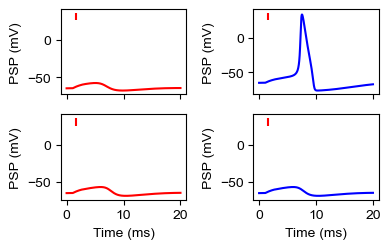

In [5]:
Stim = n.NetStim()
Stim.number = 1
Stim.start = 1

# recording IPSP, IPSC from somas and dendrites
Esst_soma_v = n.Vector().record(E_SST.Ecells[0].soma(0.5)._ref_v)
Isst_soma_v = n.Vector().record(E_SST.Icells[0].soma(0.5)._ref_v)
#sstsyn_i_dend1 = n.Vector().record(E_SST.Ecells[0].GABA_dend._ref_i)
#sstsyn_i_soma = n.Vector().record(E_SST.Ecells[0].GABA_soma._ref_i)

Epv_soma_v = n.Vector().record(E_PV.Ecells[0].soma(0.5)._ref_v)
Ipv_soma_v = n.Vector().record(E_PV.Icells[0].soma(0.5)._ref_v)
#pvsyn_i_dend1 = n.Vector().record(E_PV.Ecells[0].GABA_dend._ref_i)
#pvsyn_i_soma = n.Vector().record(E_PV.Ecells[0].GABA_soma._ref_i)

# Prepare for plotting
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'
# PSP on soma
fig, axes = plt.subplots(2, 2, figsize=(4, 2.6), sharex=True)
Types = ["Homosynp", "Heterosynp"] #, "Perisoma"]
mycols = ["red", "blue"]
for ti in range(2):
    Type = Types[ti]
    try:
        del ne_sst, ne_pv, ni_sst, ni_pv
        del ampa_i_sst, ampa_i_pv, gaba_i_sst, gaba_i_pv
        del nc, nc2
    except NameError:
        print("No action required")

    # source of excitation
    if Type == "Homosynp":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_dend)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_dend)
        ampa_i_sst = n.Vector().record(E_SST.Ecells[0].AMPA_dend._ref_i)
        gaba_i_sst = n.Vector().record(E_SST.Ecells[0].GABA_dend._ref_i)
        ampa_i_pv = n.Vector().record(E_PV.Ecells[0].AMPA_dend._ref_i)
        gaba_i_pv = n.Vector().record(E_PV.Ecells[0].GABA_soma._ref_i)
    if Type == "Heterosynp":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_dend2)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_dend2)
        ampa_i_sst = n.Vector().record(E_SST.Ecells[0].AMPA_dend2._ref_i)
        gaba_i_sst = n.Vector().record(E_SST.Ecells[0].GABA_dend._ref_i)
        ampa_i_pv = n.Vector().record(E_PV.Ecells[0].AMPA_dend2._ref_i)
        gaba_i_pv = n.Vector().record(E_PV.Ecells[0].GABA_soma._ref_i)
    if Type == "Perisoma":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_soma)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_soma)
        ampa_i_sst = n.Vector().record(E_SST.Ecells[0].AMPA_soma._ref_i)
        gaba_i_sst = n.Vector().record(E_SST.Ecells[0].GABA_dend._ref_i)
        ampa_i_pv = n.Vector().record(E_PV.Ecells[0].AMPA_soma._ref_i)
        gaba_i_pv = n.Vector().record(E_PV.Ecells[0].GABA_soma._ref_i)
    # feedforward inhibition
    ni_sst = n.NetCon(Stim, E_SST.Icells[0].AMPA)
    ni_pv = n.NetCon(Stim, E_PV.Icells[0].AMPA)
    for nc in [ne_sst, ne_pv, ni_sst, ni_pv]:    
        nc.delay = 0 * ms
        nc.weight[0] = gbar_AMPA
    for iSTDP_level in [.4]: #[.2, .3, .4, .5, .6]:
        # adjust GABAergic synaptic weight for single pulse test
        E_SST.Icells[0]._ncs[0].weight[0] = gbar_AMPA * iSTDP_level
        E_PV.Icells[0]._ncs[0].weight[0] = gbar_AMPA * iSTDP_level
        
        # Simulate
        t = n.Vector().record(n._ref_t)
        n.finitialize(-65 * mV)
        n.continuerun(20)
        # SST -> E
        axes[0,ti].plot(t, Esst_soma_v, color = mycols[ti], label="Soma")
        # axes[0,ti].plot(t, Isst_soma_v, color = "red", label="I")
        # PV -> E
        axes[1,ti].plot(t, Epv_soma_v, color = mycols[ti], label="Soma")
        # axes[1,ti].plot(t, Ipv_soma_v, color = "red", label="I")
    axes[0,ti].vlines(list(E_SST.Icells[0].spike_times), 30 - 4.5, 30 + 5.5, colors='red')
    axes[0,ti].set_ylabel("PSP (mV)")
    axes[1,ti].vlines(list(E_PV.Icells[0].spike_times), 30 - 4.5, 30 + 5.5, colors='red')
    axes[1,ti].set_ylabel("PSP (mV)")
    axes[1,ti].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(plotdir,"Compare_SST|PV_FF_PSP.pdf"), format='pdf')

- Parametrically adjusting i synaptic weights

No action required
No action required


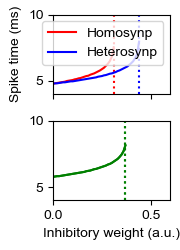

In [7]:
# Prepare for plotting
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'
ilevels = np.linspace(0,1,101)
# PSP on soma
fig, axes = plt.subplots(2, 1, figsize=(2, 2.6), sharex=True)
Types = ["Homosynp", "Heterosynp"] #, "Perisoma"]
for ti in range(2):
    Type = Types[ti]
    try:
        del ne_sst, ne_pv, ni_sst, ni_pv
        del ampa_i_sst, ampa_i_pv, gaba_i_sst, gaba_i_pv
        del nc, nc2
    except NameError:
        print("No action required")

    # source of excitation
    if Type == "Homosynp":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_dend)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_dend)
    if Type == "Heterosynp":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_dend2)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_dend2)
    if Type == "Perisoma":
        ne_sst = n.NetCon(Stim, E_SST.Ecells[0].AMPA_soma)
        ne_pv = n.NetCon(Stim, E_PV.Ecells[0].AMPA_soma)
    # feedforward inhibition
    ni_sst = n.NetCon(Stim, E_SST.Icells[0].AMPA)
    ni_pv = n.NetCon(Stim, E_PV.Icells[0].AMPA)
    for nc in [ne_sst, ne_pv, ni_sst, ni_pv]:    
        nc.delay = 0 * ms
        nc.weight[0] = gbar_AMPA
    spikeTsst = []
    spikeTpv = []
    for iSTDP_level in ilevels:
        # adjust GABAergic synaptic weight for single pulse test
        E_SST.Icells[0]._ncs[0].weight[0] = gbar_AMPA * iSTDP_level
        E_PV.Icells[0]._ncs[0].weight[0] = gbar_AMPA * iSTDP_level
        
        # Simulate
        t = n.Vector().record(n._ref_t)
        n.finitialize(-65 * mV)
        n.continuerun(20)
        sp = list(E_SST.Ecells[0].spike_times)
        if len(sp) > 0:
            spikeTsst.append(sp[0]-Stim.start)
        else:
            spikeTsst.append(np.Inf)
        sp = list(E_PV.Ecells[0].spike_times)
        if len(sp) > 0:
            spikeTpv.append(sp[0])
        else:
            spikeTpv.append(np.Inf)
    axes[0].plot(ilevels, spikeTsst, color = mycols[ti], label=Type)
    maxt = np.max(np.array(spikeTsst)[np.isfinite(spikeTsst)])
    axes[0].vlines(ilevels[np.where(np.array(spikeTsst)==maxt)[0]], 4, 10, linestyle = ":", colors=mycols[ti])
    if 1:
        axes[1].plot(ilevels, spikeTpv, color = "green", label=Type)
        maxt = np.max(np.array(spikeTpv)[np.isfinite(spikeTpv)])
        axes[1].vlines(ilevels[np.where(np.array(spikeTpv)==maxt)[0]], 4, 10, linestyle = ":", colors='green')


axes[1].set_xlabel("Inhibitory weight (a.u.)")
axes[0].set_ylabel("Spike time (ms)")
axes[0].legend()
axes[0].set_ylim(4,10)
axes[1].set_ylim(4,10)
axes[0].set_xlim(0,.6)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(plotdir,"Compare_SST|PV_FF_spikeT.pdf"), format='pdf')

In [ ]:
try:
    del my_cell, stim
except NameError:
    print("No action required")
my_cell =  ENeuron(0, 3 * µm, 12 * µm, 0, n.PI/2)
stim = n.NetStim()  # Make a new stimulator
syn_ = n.ExpSyn(my_cell.soma(0.5))
syn_.tau = AMPA_TAU
syn_.e = AMPA_RvrslP # the reversal potential of AMPA receptor

stim.number = 1
stim.start = 5
ncstim = n.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = gbar_AMPA # NetCon weight is a vector.

soma_v = n.Vector().record(my_cell.soma(0.5)._ref_v)
syn_i = n.Vector().record(syn_._ref_i)
t = n.Vector().record(n._ref_t)
n.finitialize(-65 * mV)
n.continuerun(25 * ms)

rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(2, 2, 1)
soma_plot = ax1.plot(t, soma_v, color="black", label="Soma(0.5)")
ax1.legend()
ax1.set_ylabel("Membrane potential (mV)")
ax1.set_xticks([])  # Use ax2's tick labels

ax2 = fig.add_subplot(2, 2, 3)
syn_plot = ax2.plot(t, syn_i, color="blue", label="Synaptic current")
ax2.legend()
ax2.set_ylabel("Synaptic current (" + n.units("ExpSyn.i") + ")")
ax2.set_xlabel("time (ms)")

del my_cell, stim
my_cell =  ENeuron(0, 3 * µm, 12 * µm, 0, n.PI/2)
stimE = n.NetStim()  # Make a new stimulator
synE = n.ExpSyn(my_cell.soma(0.5))
synE.tau = AMPA_TAU
synE.e = AMPA_RvrslP # the reversal potential of AMPA receptor
stimE.number = 1
stimE.start = 5
ncstim = n.NetCon(stimE, synE)
ncstim.delay = 1 * ms
ncstim.weight[0] = gbar_AMPA # NetCon weight is a vector.

stimI = n.NetStim()  # Make a new stimulator
synI = n.ExpSyn(my_cell.soma(0.5))
synI.tau = GABAA_TAU
synI.e = GABA_RvrslP # the reversal potential of AMPA receptor
stimI.number = 1
stimI.start = 5
ncstimI = n.NetCon(stimI, synI)
ncstimI.delay = 1 * ms
ncstimI.weight[0] = gbar_GABA # NetCon weight is a vector.

soma_v = n.Vector().record(my_cell.soma(0.5)._ref_v)
syn_e = n.Vector().record(synE._ref_i)
syn_i = n.Vector().record(synI._ref_i)
t = n.Vector().record(n._ref_t)
n.finitialize(-65 * mV)
n.continuerun(25 * ms)

ax3 = fig.add_subplot(2, 2, 2)
soma_plot = ax3.plot(t, soma_v, color="black", label="soma(0.5)")
ax3.legend()
ax3.set_ylabel(" ")
ax3.set_xticks([])  # Use ax2's tick labels

ax4 = fig.add_subplot(2, 2, 4)
syni_plot = ax4.plot(t, syn_i, color="red", label="GABA synaptic current")
syne_plot = ax4.plot(t, syn_e, color="blue", label="AMPA synaptic current")
ax4.legend()
ax4.set_ylabel(" ")
ax4.set_xlabel("Time (ms)")
plt.show()
fig.savefig(os.path.join(plotdir,"gbarTest_AMPA_GABAA.pdf"), format='pdf')

In [ ]:
try:
    del my_cell, stim
except NameError:
    print("No action required")
my_cell =  ENeuron(0, 3 * µm, 12 * µm, 0, n.PI/2)
stim = n.IClamp(my_cell.soma(0.5))
stim.delay = 5 # ms
stim.dur = 1 # ms
stim.amp = 0.065 # nA
soma_v = n.Vector().record(my_cell.soma(0.5)._ref_v)
syn_i = n.Vector().record(stim._ref_i)
t = n.Vector().record(n._ref_t)
n.finitialize(-65 * mV)
n.continuerun(50 * ms)
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(2, 2, 1)
soma_plot = ax1.plot(t, soma_v, color="black", label="soma(0.5)")
ax1.legend()
ax1.set_ylabel("Membrane potential (mV)")
ax1.set_xticks([])  # Use ax2's tick labels

ax2 = fig.add_subplot(2, 2, 3)
syn_plot = ax2.plot(t, syn_i, color="blue", label="synaptic current")
ax2.legend()
ax2.set_ylabel("Synaptic current (" + n.units("ExpSyn.i") + ")")
ax2.set_xlabel("Time (ms)")

del my_cell, stim
my_cell =  ENeuron(0, 3 * µm, 12 * µm, 0, n.PI/2)
stimI = n.IClamp(my_cell.soma(0.5))
stimI.delay = 5 # ms
stimI.dur = 1 # ms
stimI.amp = -0.065 # nA
stimE = n.IClamp(my_cell.soma(0.5))
stimE.delay = 5 # ms
stimE.dur = 1 # ms
stimE.amp = 0.065 # nA
soma_v = n.Vector().record(my_cell.soma(0.5)._ref_v)
syn_i = n.Vector().record(stimI._ref_i)
syn_e = n.Vector().record(stimE._ref_i)
t = n.Vector().record(n._ref_t)
n.finitialize(-65 * mV)
n.continuerun(50 * ms)

ax3 = fig.add_subplot(2, 2, 2)
soma_plot = ax3.plot(t, soma_v, color="black", label="soma(0.5)")
ax3.legend()
ax3.set_ylabel(" ")
ax3.set_xticks([])  # Use ax2's tick labels

ax4 = fig.add_subplot(2, 2, 4)
syni_plot = ax4.plot(t, syn_i, color="red", label="I synaptic current")
syne_plot = ax4.plot(t, syn_e, color="blue", label="E synaptic current")
ax4.legend()
ax4.set_ylabel(" ")
ax4.set_xlabel("Time (ms)")
plt.show()
fig.savefig(os.path.join(plotdir,"gbarTest_IClam.pdf"), format='pdf')